# Particle Filtering Gaussian State Space Model + ESS Resampling

In [1]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

## Reading Sensor Data

In [3]:
data_interface = DataInterface(
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
    "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
)

In [4]:
data = data_interface.read()

In [8]:
gps = data['gps_data']
imu = data['imu_data']
enc = data['encoders_data']

In [63]:
R = 6_371_000 #earth's radius in meters
lat0 = gps[1]
lon0 = gps[2]
z0 = gps[3]
convert_lon = 1/R
baseline = 1
#8x8
C = np.zeros(shape=(8,8), dtype=np.float32)

#longitude
C[0,0] = convert_lon
#latitude
C[1,1] = 1/R
#altitude
C[2,2] = 1

#left encoder
C[3,3] = 1
C[3,4] = -baseline/2

#right encoder
C[4,3] = 1
C[4,4] = baseline/2

#yaw, pitch, roll
C[5,5] = 180/np.pi
C[6,6] = 180/np.pi
C[7,7] = 180/np.pi

## Testing Parts of Gaussian Particle Filter

In [38]:
gps_cov = gps[4:].reshape(3,3)

### convert data -> measurement vector

In [135]:
left0,right0 = enc[1:3]

In [136]:
# data -> (lon,lat,alt,left,right,yaw,pitch,roll)
# meas_vector -> (x,y,z,v,w,yaw,pitch,roll)
lat,lon,alt = gps[1:4]
lat -= lat0
lon -= lon0
alt -= z0

pitch, roll, yaw = imu[5:8]
left,right = enc[1:3]

left -= left0
right -= right0

y_t = np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
print(y_t)

[[   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [   0.        ]
 [-168.91395626]
 [  -0.2013542 ]
 [   0.63600743]]


In [152]:
print( np.linalg.inv(C) @ y_t ) #predicted state vector

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-2.94810467]
 [-0.00351429]
 [ 0.01110042]]


### measurement matrix test

In [138]:
#measurement matrix test
x0 = np.array([[50,100,5,10,20,np.pi/2,np.pi/8,0]]).T
meas = C @ x0

In [139]:
meas

array([[7.84806176e-06],
       [1.56961235e-05],
       [5.00000000e+00],
       [0.00000000e+00],
       [2.00000000e+01],
       [9.00000011e+01],
       [2.25000003e+01],
       [0.00000000e+00]])

### transition function test

In [140]:
def stateUpdate(state):
    x,y,z,v,w,yaw,pitch,roll = state[:,0]
    x = x + v*np.cos(pitch)*np.cos(yaw)
    y = y + v*np.cos(pitch)*np.sin(yaw)
    z = z + v*np.sin(pitch)
    
    yaw = yaw + w
    pitch = pitch
    roll = roll
    state_ = np.array([[x,y,z,v,w,yaw,pitch,roll]]).T
    return state_

In [141]:
stateUpdate(x0)

array([[ 50.        ],
       [109.23879533],
       [  8.82683432],
       [ 10.        ],
       [ 20.        ],
       [ 21.57079633],
       [  0.39269908],
       [  0.        ]])

### Particles Initialization

In [191]:
np.linalg.inv(C) @ y_t

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-2.94810467],
       [-0.00351429],
       [ 0.01110042]])

In [200]:
Q = np.eye(8,dtype=np.float32)*1
Q_inv = np.linalg.inv(Q)

R = np.eye(8,dtype=np.float32)*1
R[0:3,0:3] = gps_cov
R_inv = np.linalg.inv(R)

sig0 = np.linalg.inv(Q_inv + C.T @ R_inv @ C)
mu0  = sig0 @ ( C.T @ R_inv @ y_t )

n_particles = 100
particle = np.random.multivariate_normal(mu0.flatten(),sig0, size=(1))

In [201]:
particle.T

array([[ 0.26792008],
       [ 1.19489949],
       [ 0.19783384],
       [ 0.86580264],
       [-0.06786221],
       [-2.94307601],
       [ 0.01776052],
       [-0.00714322]])

In [202]:
particles = np.random.multivariate_normal(mu0.flatten(),sig0, size=(n_particles,))
print(particles.shape)

(100, 8)


### weight initialization

In [203]:
pred = np.linalg.inv(C) @ y_t

meas_pred_dist = (y_t - C@pred)
weight = np.exp(-0.5 *  (meas_pred_dist.T @ np.linalg.inv(sig0) @ meas_pred_dist) )[0,0]

In [204]:
particles = np.random.multivariate_normal(mu0.flatten(),sig0, size=(n_particles,))
weights = np.zeros((n_particles,), dtype=np.float32)
w_sum = 0
for i in range(n_particles):
    x_t = particles[i,:].reshape(8,1)
    
    weights[i] = ((y_t - C@x_t).T @ np.linalg.inv(sig0) @ (y_t - C@x_t))[0,0]
    w_sum += weights[i]
weights /= w_sum

In [205]:
weights

array([0.0058889 , 0.00597619, 0.00392213, 0.00244542, 0.00273   ,
       0.02690526, 0.0180385 , 0.00588423, 0.00547877, 0.01266975,
       0.0044848 , 0.00389862, 0.00388151, 0.00805521, 0.02076542,
       0.01175709, 0.00625002, 0.01432009, 0.01733617, 0.03486006,
       0.00744261, 0.00648139, 0.01141597, 0.00578911, 0.00393801,
       0.01025887, 0.00331567, 0.0121462 , 0.00135095, 0.01881763,
       0.01142744, 0.00279454, 0.01156397, 0.00979129, 0.0024518 ,
       0.00556138, 0.01682503, 0.01138375, 0.00682339, 0.0149658 ,
       0.01193875, 0.01573511, 0.00590061, 0.00699359, 0.00115944,
       0.00863901, 0.00446634, 0.00504485, 0.00280024, 0.00215529,
       0.01352596, 0.00697158, 0.00460721, 0.00864204, 0.00328706,
       0.01478305, 0.00699332, 0.0075496 , 0.01029221, 0.0053674 ,
       0.00282281, 0.00264397, 0.01746348, 0.01682925, 0.00687911,
       0.00104168, 0.0052379 , 0.00733488, 0.00506254, 0.00457984,
       0.0106075 , 0.00714257, 0.01693321, 0.00269008, 0.01782

### ESS Calculator

In [206]:
ESS = 1 / np.sum( weights**2 )
print(ESS)

64.29010069807457


### Make Prediction and Visualize Particles

In [207]:
avg = np.sum( particles * weights.reshape(n_particles,1), axis=0)

In [209]:
avg

array([-1.09045298e-02,  1.42785121e-01, -1.68207370e-03,  1.20044716e-02,
       -7.06817627e-04, -2.95156910e+00, -2.83626960e-03,  8.83430934e-03])

(100, 3)


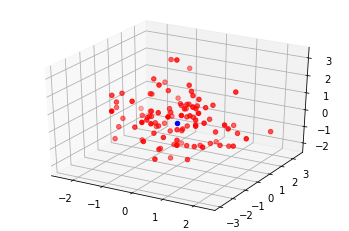

In [212]:
x0 = np.linalg.inv(C) @ y_t

data = particles[:,:3]
print(data.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x0[0,:], x0[1,:], x0[2,:],c='blue')
ax.scatter(data[:,0], data[:,1], data[:,2], c='red')
plt.show()

## Full Gaussian Particle Filter Implementation

In [36]:
class GaussianParticleFilter:
    def __init__(self, systemCov, measCov, stateUpdate, measMatrix, initialMeas, n_particles=100):
        '''
            systemCov = State Update Covariance Matrix
            measCov = Measurement Covariance Matrix (Sensor Covariances)
            stateUpdate = python function that takes in previous state and predicts next state
            measMatrix = matrix that converts state vector to measurement vector
            initialState = starting off state
        '''
        
        #standard setting up A,C,Q,R
        self.stateUpdate = stateUpdate
        self.Q = systemCov
        self.R = measCov
        self.C = measMatrix
        
        self.x0 = initialState
        self.y0 = initialMeas
        
        #setup for easier computation
        Q_inv = np.linalg.inv(self.Q)
        R_inv = np.linalg.inv(self.R)
        
        self.sig = np.linalg.inv(self.C.T @ R_inv @ self.C)
        
        #initial Mu
        mu0  = sig0 @ ( self.C.T @ R_inv @ self.y0)
        
        #initialize particles
        self.particle_states = np.random.multivariate_normal(mu0,self.sig,size=(n_particles,))
        self.weights = np.zeros(self.particle_states.shape, dtype=np.float32)
        inv_cov = np.linalg.inv( self.Q + C @ self.R @ C.T )
        sum_weights = 0
        for i in range(n_particles):
            x_est = self.particle_states[i]
            weight = np.exp( -0.5 * (self.y0 - self.C @ x_est).T @ (inv_cov) @ (self.y0 - self.C @ x_est) )
            self.weights[i] = weight
            sum_weights += weight
        self.weights /= sum_weights #normalize weights
        
        self.n_particles = n_particles
        self.ESS = None
        
    def update(self, measVector):
        inv_cov = np.linalg.inv( self.Q + C @ self.R @ C.T )
        Q_inv = np.linalg.inv(self.Q)
        R_inv = np.linalg.inv(self.R)
        sum_weights = 0
        for i in range(n_particles):
            f_x1 = self.stateUpdate( self.particle_states[i] )
            
            mu = self.sig @ (Q_inv @ f_x1 + C.T @ R_inv @ measVector)
            
            particle = np.random.multivariate_normal(mu,self.sig)
            
            weight = np.exp( -0.5 * (measVector - self.C @ f_x1).T @ (inv_cov) @ (measVector - self.C @ f_x1) )
            self.weights[i] = weight
            self.particle_states[i] = particle
            sum_weights += weight
        self.weights /= sum_weights #normalize weights
        
    def calcESS(self):
        sum_normals = 0
        for i in range(n_parcles):
            sum_normals += self.weights[i]**2
        self.ESS = 1 / sum_normals   
        
        return self.ESS
    def resample(self):
        pass
    def getEstimate(self):
        avg = np.zeros(self.particle_states[0].shape,dtype=np.float32)
        for i in range(self.n_particles):
            avg += self.weights[i]*self.particle_states[i]
        return avg